In [5]:
import numpy as np
import torch

In [147]:
# data = np.zeros((2, 8 * 64 * 64)) # 8, 64, 64))
data = np.zeros((2, 8, 64, 64))
meshgrid_args = [np.arange(s) for s in data.shape[1:]]
positions = np.array(
    np.meshgrid(
        *meshgrid_args,
        indexing="ij"
    ),
)
# move the first dimension to the end
orig_shape = tuple(range(len(positions.shape)))
transposed_shape = orig_shape[1:] + (orig_shape[0],)
positions = positions.transpose(*transposed_shape)
print(positions.shape)
# print(positions[0, 0, 0])
# print(positions[2, 1, 0])

(32768, 1)


In [148]:
positions_flat = positions.reshape(-1, positions.shape[-1])
print(positions_flat.shape)
print(positions_flat[0])
print(positions_flat[2])

(32768, 1)
[0]
[2]


In [152]:
def find_sparse_context_window(target_idx: int, positions, block_size, sparse_block_size):
    # positions: (N, 3)
    # target_idx: (3,)
    # block_size: int
    # returns: (block_size, 3)
    # find the block_size closest points to the target_idx
    # using the L2 distance
    # look back at most block_size points
    start_idx = max(0, target_idx - block_size)
    target_position = positions[target_idx]
    # print("target pos:", target_position)
    distances = np.linalg.norm(positions[start_idx:target_idx] - target_position, axis=1)
    distances_exponential = np.exp(-distances)
    distances_exponential += np.random.rand(*distances_exponential.shape) * 1e-1
    
    # print(distances.shape)
    # print("distances:", distances_exponential)
    sorted_indices = np.argsort(-distances_exponential)
    # print("sorted indices:", sorted_indices)
    context_token_idx = np.arange(start_idx, target_idx)[sorted_indices[:sparse_block_size]]
    relative_pos = target_position - positions[context_token_idx]
    return context_token_idx, relative_pos


target_idx = 4096 * 2+ 1100 
block_size = int(4096 * 1.5)
sparse_block_size = 128

context_token_idx, relative_pos = find_sparse_context_window(
    target_idx,
    positions_flat,
    block_size,
    sparse_block_size,
)
print(context_token_idx)
print("target pos:", positions_flat[target_idx-1])
print("nearest neighbor:", positions_flat[context_token_idx[0] - 1])
print("nearest neighbor:", positions_flat[context_token_idx[1] - 1])
print("relative pos:", relative_pos[0:2])

[9291 9290 9289 9054 6573 4090 6503 9098 5374 5279 7018 5764 5528 7146
 3347 3649 4026 9217 4171 7626 8966 6710 7853 6517 4853 4597 7417 6524
 3241 6474 8075 3539 7286 6941 6353 6738 4909 6575 7993 5243 3239 9125
 5163 4379 9115 8463 7624 7566 4414 3456 9253 7436 7729 4214 9181 4872
 8898 7778 3694 4640 8261 6046 8151 4741 9094 3805 6754 5339 7021 8266
 5748 7790 4501 8842 8024 6714 7240 5550 4700 4610 4205 4626 7468 8690
 5934 5888 9074 6511 4532 8968 8493 6942 5418 7557 5557 8320 6214 5604
 8163 8177 6545 6352 3458 7701 9099 6306 9069 8073 3982 8913 4964 9162
 3963 3232 5520 3976 5146 7838 9268 8974 6623 5684 6610 6284 8779 4833
 8883 8585]
target pos: [9291]
nearest neighbor: [9290]
nearest neighbor: [9289]
relative pos: [[1]
 [2]]


target pos: [ 2 17 12]
0.0078125


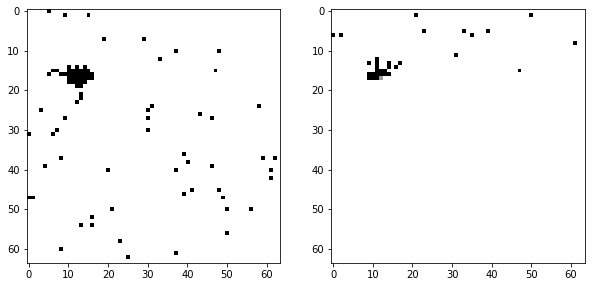

In [125]:
# visualize the context window
import matplotlib.pyplot as plt

# plt.figure()
target_pos = positions_flat[target_idx]
print("target pos:", target_pos)
# last 2 dims of target_pos is the x, y coordinate
# draw that in a 2D image

frame = np.zeros((64, 64), dtype=np.uint8)
previous_frame = frame.copy()
frame[int(target_pos[1]), int(target_pos[2])] = 100

# draw the context window
context_positions = positions_flat[context_token_idx]
context_positions = context_positions.astype(int)
# print("context positions:", context_positions)
for pos in context_positions:
    # print(f"pos0={pos[0]}, target_pos0={target_pos[0]}")
    if int(pos[0]) == int(target_pos[0]):
        frame[pos[1], pos[2]] = 255
        # print("context pos:", pos)
    elif int(pos[0]) == int(target_pos[0]) - 1:
        previous_frame[pos[1], pos[2]] = 100
        

print((frame != 0).mean())
# do a subplot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(255 - previous_frame, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(255 - frame, cmap="gray")

In [107]:
def pad_seq(context_idx, sparse_block_size, value=-1):
    # context_idx: (sparse_block_size,)
    # returns: (sparse_block_size,)
    # pad the context_idx to the sparse_block_size
    padded = np.ones((sparse_block_size,), dtype=np.int64) * value
    padded[:len(context_idx)] = context_idx
    return padded

In [141]:
from tqdm.auto import tqdm

block_size = int(4096 * 1.5)
sparse_block_size = 128

tokens_flat = np.arange(len(positions_flat))
tokens_flat_padded = np.concatenate(
    [np.ones((1,), dtype=np.int64) * -1,
    tokens_flat],
    axis=0,
)
positions_flat_padded = np.concatenate(
    [np.ones((1, 3), dtype=np.int64) * -1,
    positions_flat],
    axis=0,
)
# print(positions_flat_padded)


relative_pos_lut = []
context_token_idx_lut = []
for target_idx in tqdm(range(len(positions_flat))):
    context_token_idx, relative_pos = find_sparse_context_window(
        target_idx,
        positions_flat,
        block_size,
        sparse_block_size,
    )
    relative_pos_padded = np.concatenate(
        [relative_pos, np.zeros((sparse_block_size - len(relative_pos), 3))],
        axis=0,
    )
    # This assumes the positions and tokens will be inserted with a start token
    context_token_idx_padded = pad_seq(context_token_idx, sparse_block_size) + 1
    if target_idx in [0, 2]:
        print("target_idx:", target_idx, "target_pos:", positions_flat[target_idx])
        # print("context token idx padded:", context_token_idx_padded)
        print("context position", positions_flat_padded[context_token_idx_padded[0:3]])
        print("relative pos:", relative_pos_padded[:3])
        print("context tokens:", tokens_flat_padded[context_token_idx_padded[0:3]])
        print("-" * 50)
    
    relative_pos_lut.append(relative_pos_padded)
    context_token_idx_lut.append(context_token_idx_padded)

    if target_idx > 100:
        break

relative_pos_lut = np.stack(relative_pos_lut, axis=0)
context_token_idx_lut = np.stack(context_token_idx_lut, axis=0)
print(relative_pos_lut.shape)
print(context_token_idx_lut.shape)

  0%|          | 101/32768 [00:00<00:02, 12247.03it/s]

target_idx: 0 target_pos: [0 0 0]
context position [[-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]]
relative pos: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
context tokens: [-1 -1 -1]
--------------------------------------------------
target_idx: 2 target_pos: [0 0 2]
context position [[ 0  0  1]
 [ 0  0  0]
 [-1 -1 -1]]
relative pos: [[0. 0. 1.]
 [0. 0. 2.]
 [0. 0. 0.]]
context tokens: [ 1  0 -1]
--------------------------------------------------
(102, 128, 3)
(102, 128)


In [160]:
x = torch.concatenate([torch.tensor([0]), torch.tensor([1])])
print(x)
idx = np.zeros((1,)).astype(int)
print(idx)
x[idx]

tensor([0, 1])
[0]


tensor([0])